In [69]:
from sklearn.svm import SVC
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import  confusion_matrix, classification_report
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from utils import calculate_metrics

# Original Dataset

In [70]:
# Load the data
df = pd.read_csv('../../data/processed/heart_se.csv')
# Split the data into features and target variable
X = df.drop(['target','index'], axis=1)
y = df['target']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [71]:
# Define the objective function to be optimized
def objective(trial):
    # Suggest values for the hyperparameters
    C = trial.suggest_float('C', 0.1, 10.0, log=True)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    degree = trial.suggest_int('degree', 2, 5) if kernel == 'poly' else 3
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    coef0 = trial.suggest_float('coef0', 0.0, 1.0)
    shrinking = trial.suggest_categorical('shrinking', [True, False])
    tol = trial.suggest_float('tol', 1e-5, 1e-2, log=True)
    cache_size = trial.suggest_float('cache_size', 100.0, 500.0)
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])
    max_iter = trial.suggest_int('max_iter', 1000, 10000)
    decision_function_shape = trial.suggest_categorical('decision_function_shape', ['ovo', 'ovr'])
    
    # Only allow break_ties to be True if decision_function_shape is 'ovr'
    if decision_function_shape == 'ovr':
        break_ties = trial.suggest_categorical('break_ties', [True, False])
    else:
        break_ties = False

    # Create an SVM classifier with the suggested hyperparameters
    svm = SVC(
        C=C,
        kernel=kernel,
        degree=degree,
        gamma=gamma,
        coef0=coef0,
        shrinking=shrinking,
        probability=False,  # Keeping probability as False for optimization
        tol=tol,
        cache_size=cache_size,
        class_weight=class_weight,
        verbose=False,  # Verbose mode off for optimization
        max_iter=max_iter,
        decision_function_shape=decision_function_shape,
        break_ties=break_ties,
        random_state=42
    )

    # Use cross-validation to evaluate the model
    score = cross_val_score(svm, X_train, y_train, n_jobs=-1, cv=3)
    accuracy = score.mean()

    return accuracy

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)

# Train the final model with the best hyperparameters
svm = SVC(**best_params)
svm.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = svm.predict(X_test)

# Evaluate the final model
accuracy = svm.score(X_test, y_test)
print(f"Test set accuracy: {accuracy:.2f}")

[I 2024-08-30 11:28:23,571] A new study created in memory with name: no-name-f1397d12-6362-4c3a-a5d8-96f1bba0cfe9


[I 2024-08-30 11:28:25,053] Trial 0 finished with value: 0.8264403292181068 and parameters: {'C': 0.495552491792398, 'kernel': 'poly', 'degree': 2, 'gamma': 'scale', 'coef0': 0.05993967811409673, 'shrinking': False, 'tol': 0.0013438955057309895, 'cache_size': 298.0915812478429, 'class_weight': 'balanced', 'max_iter': 1803, 'decision_function_shape': 'ovo'}. Best is trial 0 with value: 0.8264403292181068.
[I 2024-08-30 11:28:25,407] Trial 1 finished with value: 0.818261316872428 and parameters: {'C': 0.3866757382040587, 'kernel': 'poly', 'degree': 4, 'gamma': 'auto', 'coef0': 0.3519972054853656, 'shrinking': False, 'tol': 0.00022174845251342153, 'cache_size': 363.2843349406044, 'class_weight': 'balanced', 'max_iter': 3852, 'decision_function_shape': 'ovr', 'break_ties': True}. Best is trial 0 with value: 0.8264403292181068.
/Users/edoardotavassi/Documents/coding_projects/heart/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_i

Best hyperparameters: {'C': 3.1635742676807204, 'kernel': 'poly', 'degree': 4, 'gamma': 'auto', 'coef0': 0.35400392013362486, 'shrinking': False, 'tol': 9.548408053669031e-05, 'cache_size': 203.0694984758047, 'class_weight': 'balanced', 'max_iter': 4915, 'decision_function_shape': 'ovo'}
Test set accuracy: 0.87


In [72]:
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_parallel_coordinate, plot_slice

# Plot the optimization history
opt_history = plot_optimization_history(study)
opt_history.show()


In [73]:
# Plot the hyperparameter importances
param_importance = plot_param_importances(study)
param_importance.show()

In [74]:
# Plot including all hyperparameters, even if some dominate
parallel_coordinate = plot_parallel_coordinate(study, params=study.best_params.keys())
parallel_coordinate.show()

In [75]:

# Plot the slice plot for each hyperparameter
slice_plot = plot_slice(study)
slice_plot.show()

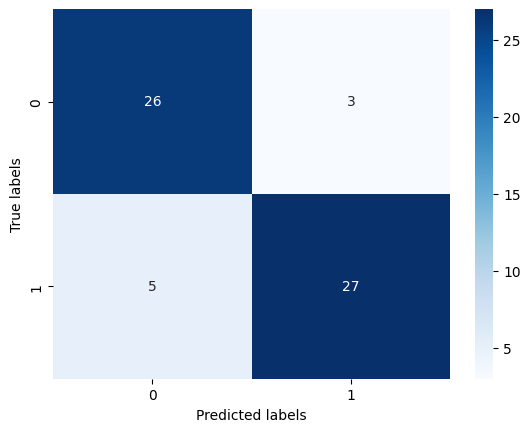

In [76]:
#test the model with the best hyperparameters
y_pred = svm.predict(X_test)
#plot the confusion matrix 
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()



In [77]:
# Generate a classification report
cls_report = classification_report(y_test, y_pred)
print(cls_report)

              precision    recall  f1-score   support

           0       0.84      0.90      0.87        29
           1       0.90      0.84      0.87        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



In [78]:
calculate_metrics(y_test, y_pred, output_file='svm')

Metrics saved to ./results/original/svm


# Rebalanced

In [79]:
# Load the data
df_train = pd.read_csv('../../data/processed/resampled/heart_resampled_train_se.csv')
df_test = pd.read_csv('../../data/processed/resampled/heart_resampled_test_se.csv')

# Split the data into features and target variable
X_train = df_train.drop(['target','index'], axis=1)
y_train = df_train['target']
X_test = df_test.drop(['target','index'], axis=1)
y_test = df_test['target']

In [80]:
# Define the objective function to be optimized
def objective(trial):
    # Suggest values for the hyperparameters
    C = trial.suggest_float('C', 0.1, 10.0, log=True)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    degree = trial.suggest_int('degree', 2, 5) if kernel == 'poly' else 3
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    coef0 = trial.suggest_float('coef0', 0.0, 1.0)
    shrinking = trial.suggest_categorical('shrinking', [True, False])
    tol = trial.suggest_float('tol', 1e-5, 1e-2, log=True)
    cache_size = trial.suggest_float('cache_size', 100.0, 500.0)
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])
    max_iter = trial.suggest_int('max_iter', 1000, 10000)
    decision_function_shape = trial.suggest_categorical('decision_function_shape', ['ovo', 'ovr'])
    
    # Only allow break_ties to be True if decision_function_shape is 'ovr'
    if decision_function_shape == 'ovr':
        break_ties = trial.suggest_categorical('break_ties', [True, False])
    else:
        break_ties = False

    # Create an SVM classifier with the suggested hyperparameters
    svm = SVC(
        C=C,
        kernel=kernel,
        degree=degree,
        gamma=gamma,
        coef0=coef0,
        shrinking=shrinking,
        probability=False,  # Keeping probability as False for optimization
        tol=tol,
        cache_size=cache_size,
        class_weight=class_weight,
        verbose=False,  # Verbose mode off for optimization
        max_iter=max_iter,
        decision_function_shape=decision_function_shape,
        break_ties=break_ties,
        random_state=42
    )

    # Use cross-validation to evaluate the model
    score = cross_val_score(svm, X_train, y_train, n_jobs=-1, cv=3)
    accuracy = score.mean()

    return accuracy

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)

# Train the final model with the best hyperparameters
svm = SVC(**best_params)
svm.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = svm.predict(X_test)

# Evaluate the final model
accuracy = svm.score(X_test, y_test)
print(f"Test set accuracy: {accuracy:.2f}")

[I 2024-08-30 11:28:49,283] A new study created in memory with name: no-name-dd2abbb7-b1ec-4470-8678-0b4c504ea2e2
[I 2024-08-30 11:28:49,300] Trial 0 finished with value: 0.8436955764541971 and parameters: {'C': 0.7781016009834236, 'kernel': 'linear', 'gamma': 'scale', 'coef0': 0.7597522082879619, 'shrinking': True, 'tol': 0.0007978716811417408, 'cache_size': 317.2983010834335, 'class_weight': 'balanced', 'max_iter': 2808, 'decision_function_shape': 'ovo'}. Best is trial 0 with value: 0.8436955764541971.
[I 2024-08-30 11:28:49,315] Trial 1 finished with value: 0.8436520376175549 and parameters: {'C': 1.9364489975531782, 'kernel': 'poly', 'degree': 5, 'gamma': 'auto', 'coef0': 0.26995816548116547, 'shrinking': True, 'tol': 0.0014919004731706214, 'cache_size': 393.1879693329369, 'class_weight': 'balanced', 'max_iter': 4526, 'decision_function_shape': 'ovr', 'break_ties': False}. Best is trial 0 with value: 0.8436955764541971.
[I 2024-08-30 11:28:49,330] Trial 2 finished with value: 0.835

Best hyperparameters: {'C': 3.2616347857563994, 'kernel': 'sigmoid', 'gamma': 'auto', 'coef0': 0.3773161579043347, 'shrinking': False, 'tol': 0.0031190542481097728, 'cache_size': 246.64068901606, 'class_weight': 'balanced', 'max_iter': 6820, 'decision_function_shape': 'ovr', 'break_ties': False}
Test set accuracy: 0.87


In [81]:
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_parallel_coordinate, plot_slice

# Plot the optimization history
opt_history = plot_optimization_history(study)
opt_history.show()


In [82]:
# Plot the hyperparameter importances
param_importance = plot_param_importances(study)
param_importance.show()

In [83]:
# Plot including all hyperparameters, even if some dominate
parallel_coordinate = plot_parallel_coordinate(study, params=study.best_params.keys())
parallel_coordinate.show()

In [84]:

# Plot the slice plot for each hyperparameter
slice_plot = plot_slice(study)
slice_plot.show()

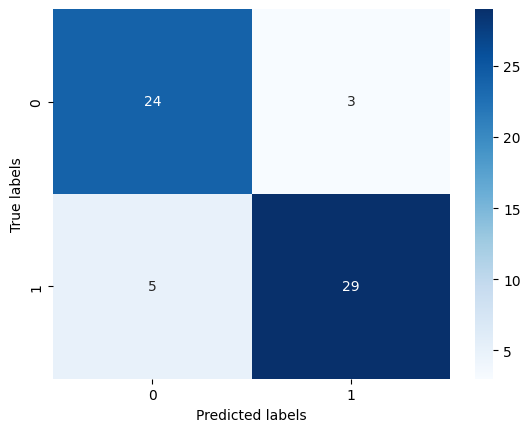

In [85]:
#test the model with the best hyperparameters
y_pred = svm.predict(X_test)
#plot the confusion matrix 
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()



In [86]:
# Generate a classification report
cls_report = classification_report(y_test, y_pred)
print(cls_report)

              precision    recall  f1-score   support

           0       0.83      0.89      0.86        27
           1       0.91      0.85      0.88        34

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



In [87]:
calculate_metrics(y_test, y_pred, output_file='svm', rebalanced=True)

Metrics saved to ./results/rebalanced/svm


# Hand Model

In [88]:
svm  = SVC(C=0.1, kernel='rbf', degree=2)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

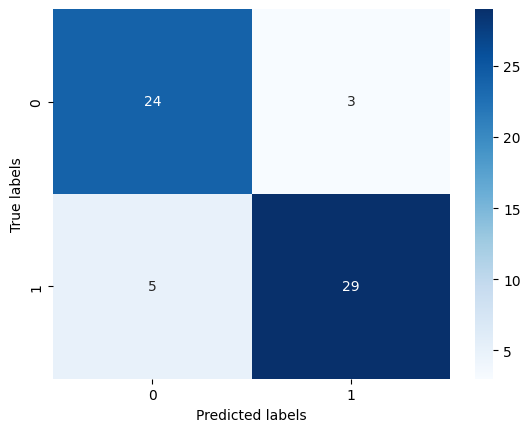

In [89]:
#plot the confusion matrix 
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


In [90]:
# Generate a classification report
cls_report = classification_report(y_test, y_pred)
print(cls_report)

              precision    recall  f1-score   support

           0       0.83      0.89      0.86        27
           1       0.91      0.85      0.88        34

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61

